# Inspired from work by Jencka and Adams

In [122]:
import pandas as pd
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

In [123]:
header = ("X", "Y", "Z", "TIME", "SLURM_NNODES", "SLURM_NTASKS_PER_NODE", "OMP_NUM_THREADS", "SLURM_GPUS_PER_NODE", "GFLOPS")

In [124]:
dat_hopper = pd.read_csv('global_results.csv', names=header)
dat_hopper = dat_hopper.dropna()
dat_hopper['Cluster'] = 'Hopper'
dat_hopper.loc[dat_hopper['SLURM_GPUS_PER_NODE'] > 0, 'Cluster'] = "Hopper (GPU)"

In [125]:
# Trim initial malformed results
dat_hopper = dat_hopper.iloc[1185:]

In [126]:
data = pd.concat((dat_hopper,))
data

,X,Y,Z,TIME,SLURM_NNODES,SLURM_NTASKS_PER_NODE,OMP_NUM_THREADS,SLURM_GPUS_PER_NODE,GFLOPS,Cluster
1185,8,8.0,8.0,90.0,1.0,2.0,1.0,2.0,0.014596,Hopper (GPU)
1186,8,8.0,32.0,90.0,1.0,2.0,1.0,2.0,0.028943,Hopper (GPU)
1187,8,8.0,56.0,90.0,1.0,2.0,1.0,2.0,0.050927,Hopper (GPU)
1188,8,8.0,8.0,90.0,4.0,1.0,1.0,1.0,5.508880,Hopper (GPU)
1189,8,8.0,32.0,90.0,4.0,1.0,1.0,1.0,10.878000,Hopper (GPU)
...,...,...,...,...,...,...,...,...,...,...
16780,32,56.0,24.0,90.0,4.0,1.0,4.0,0.0,9.055280,Hopper
16781,32,56.0,32.0,90.0,4.0,1.0,4.0,0.0,8.809620,Hopper
16782,32,56.0,40.0,90.0,4.0,1.0,4.0,0.0,8.598380,Hopper
16783,32,64.0,8.0,90.0,4.0,1.0,4.0,0.0,9.440960,Hopper


In [132]:
data['Process Count'] = data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'] * data['OMP_NUM_THREADS']
data['Process Count'].unique()

array([  2.,   4.,   1.,  32.,  64.,  16., 128.,   8.])

In [133]:
data['Problem Size'] = data['X'] * data['Y'] * data['Z']
print(data['Problem Size'].max() ** (1.0 / 3.0))

data['Global Problem Size'] = data['Problem Size'] * ((data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE']) ** 3.0)
print(data['Global Problem Size'].max() ** (1.0 / 3.0))

82.30621182481418
2994.1941639299735


In [134]:
data['SLURM_GPUS_PER_NODE'].max()

2.0

In [135]:
data['OMP_NUM_THREADS'].max()

32.0

# Plots

In [136]:
def label_peaks(df, groupby, value, troughs=False):
    mean = df.groupby(groupby).mean(numeric_only=True)[value]
    idx, _ = signal.find_peaks(mean)
    peaks = mean.iloc[idx]

    if troughs:
        idx, _ = signal.find_peaks(-mean)
        peaks = pd.concat((peaks, mean.iloc[idx]))

    for (x, y) in peaks.items():
        plt.text(x, y, str(x), path_effects=[pe.withStroke(linewidth=4, foreground="white")])

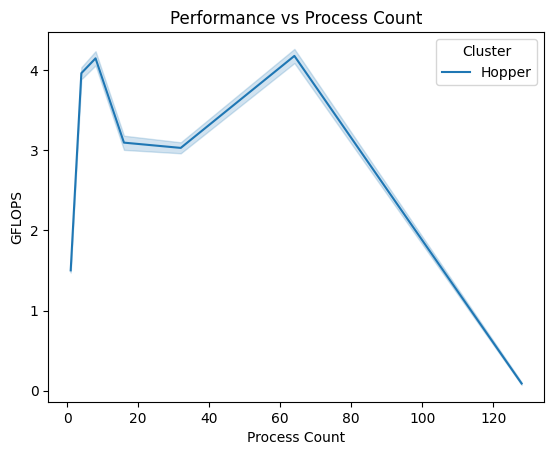

In [137]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count.svg')

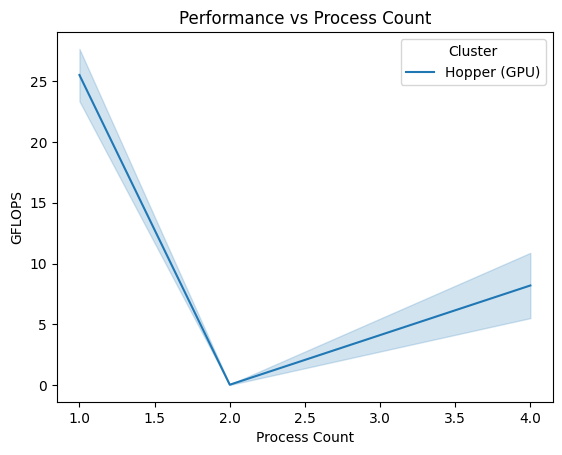

In [138]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count_gpu.svg')

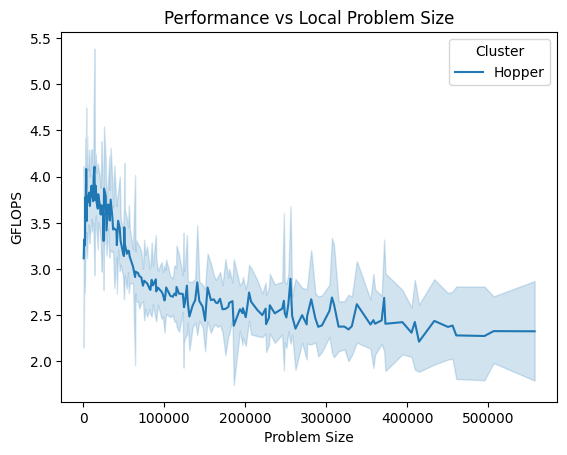

In [139]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Local Problem Size')
plt.savefig('figures/flops_local_problem_size.svg')

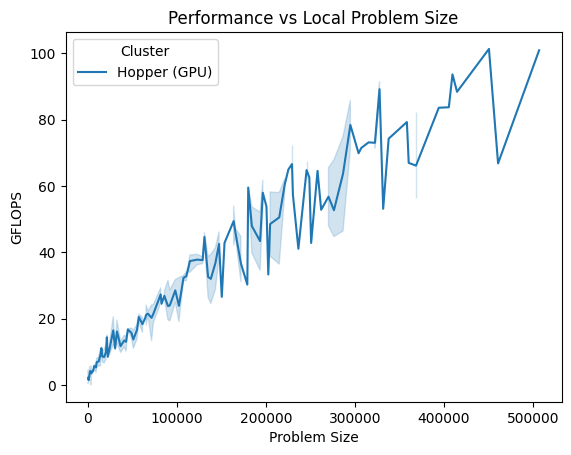

In [140]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Local Problem Size')
plt.savefig('figures/flops_local_problem_size_gpu.svg')

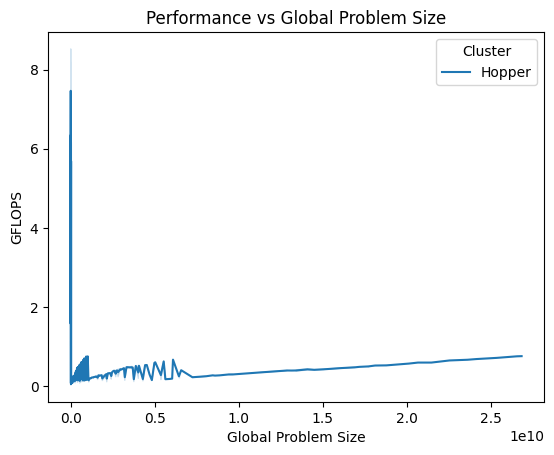

In [141]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Global Problem Size')
plt.savefig('figures/flops_global_problem_size.svg')

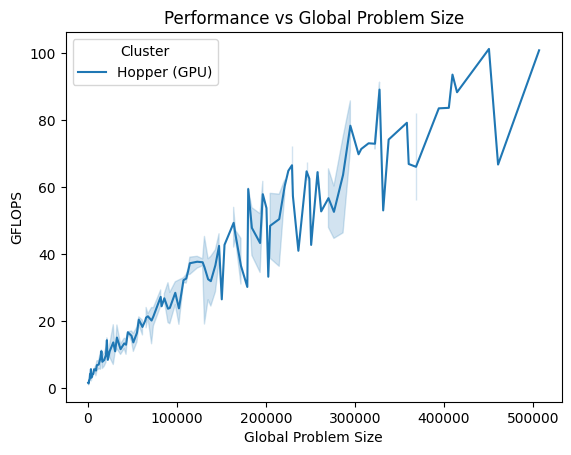

In [142]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Global Problem Size')
plt.savefig('figures/flops_global_problem_size_gpu.svg')

# Statistics

In [143]:
# Summary Stats for performance of ALL runs
stats_all_runs = data["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_all_runs

count    15599.000000
mean         3.661463
std          5.193733
min          0.014596
25%          1.893540
50%          2.822200
75%          4.190915
90%          5.768430
95%          7.593522
99%         22.743818
max        101.310000
Name: GFLOPS, dtype: float64

In [144]:
# Summary stats for Hopper
stats_hopper = data[data['Cluster'] == 'Hopper']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper

count    15216.000000
mean         3.118988
std          1.900458
min          0.019409
25%          1.875870
50%          2.781285
75%          4.083480
90%          5.589690
95%          6.360730
99%          9.489704
max         11.906300
Name: GFLOPS, dtype: float64

In [145]:
# Summary stats for Hopper (GPU)
stats_hopper_gpu = data[data['Cluster'] == 'Hopper (GPU)']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper_gpu

count    383.000000
mean      25.213124
std       21.913076
min        0.014596
25%        8.216705
50%       17.441700
75%       35.368650
90%       59.881040
95%       69.862730
99%       88.925212
max      101.310000
Name: GFLOPS, dtype: float64

In [146]:
# latex
print(pd.concat([stats_all_runs, stats_hopper, stats_hopper_gpu], axis=1).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &        GFLOPS &        GFLOPS &      GFLOPS \\
\midrule
count &  15599.000000 &  15216.000000 &  383.000000 \\
mean  &      3.661463 &      3.118988 &   25.213124 \\
std   &      5.193733 &      1.900458 &   21.913076 \\
min   &      0.014596 &      0.019409 &    0.014596 \\
25\%   &      1.893540 &      1.875870 &    8.216705 \\
50\%   &      2.822200 &      2.781285 &   17.441700 \\
75\%   &      4.190915 &      4.083480 &   35.368650 \\
90\%   &      5.768430 &      5.589690 &   59.881040 \\
95\%   &      7.593522 &      6.360730 &   69.862730 \\
99\%   &     22.743818 &      9.489704 &   88.925212 \\
max   &    101.310000 &     11.906300 &  101.310000 \\
\bottomrule
\end{tabular}



# Gustafson's like

In [147]:
one_thread = data[data['OMP_NUM_THREADS'] == 1]

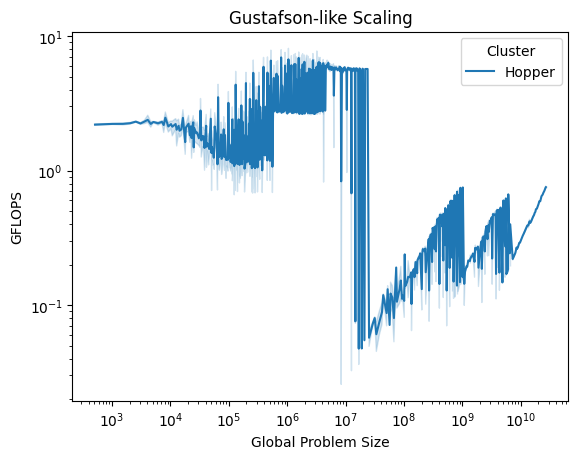

In [148]:
sns.lineplot(one_thread[one_thread['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson.svg')

In [149]:
past_3e6 = one_thread[one_thread['Global Problem Size'] > .25e10]

In [150]:
pre_3e6 = one_thread[one_thread['Global Problem Size'] < 1e9]

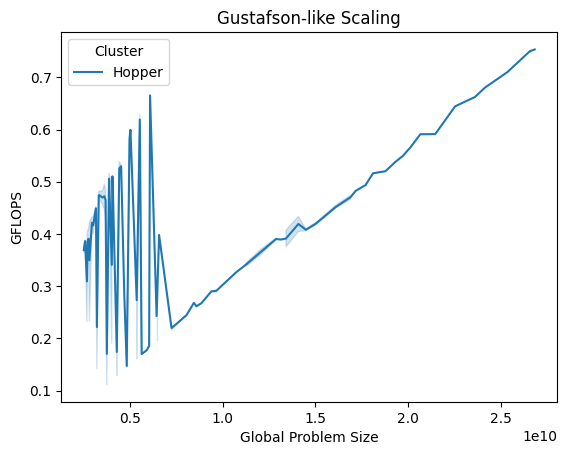

In [151]:
sns.lineplot(past_3e6[past_3e6['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_big.svg')

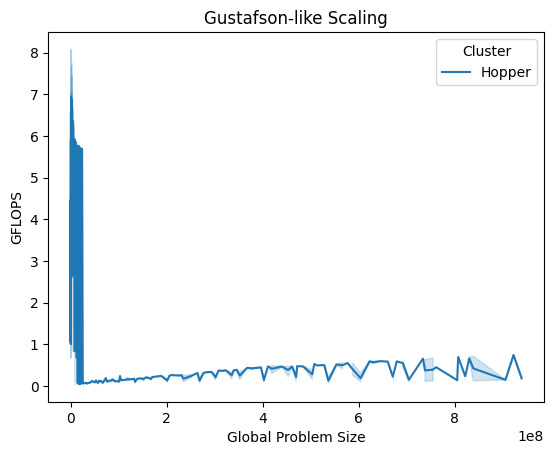

In [152]:
sns.lineplot(pre_3e6[pre_3e6['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_small.svg')

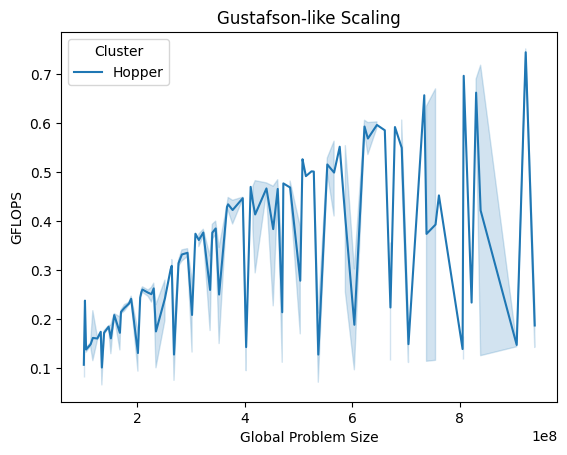

In [153]:
cutlow = pre_3e6[pre_3e6['Global Problem Size'] > 1e8]
sns.lineplot(cutlow[cutlow['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_small_cutlow.svg')

# Cubic

In [154]:
local_cube_root = data['Problem Size'].pow(1.0 / 3.0)
global_cube_root = data['Global Problem Size'].pow(1.0 / 3.0)
data["Local close to cube"] = np.sqrt(((local_cube_root - data['X']) ** 2.0) + ((local_cube_root - data['Y']) ** 2.0) + ((local_cube_root - data['Z']) ** 2.0))
data["Global close to cube"] = np.sqrt(((global_cube_root - (data['X'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0) + \
                                        ((global_cube_root - (data['Y'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0) + \
                                        ((global_cube_root - (data['Z'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0))

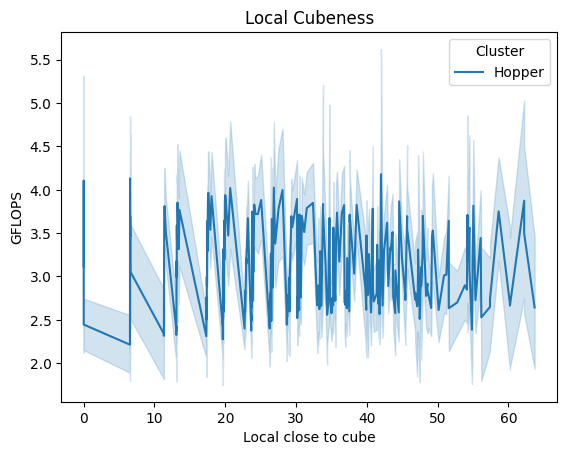

In [155]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Local close to cube", y="GFLOPS", hue='Cluster')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Local Cubeness')
plt.savefig('figures/flops_cubeness_local.svg')

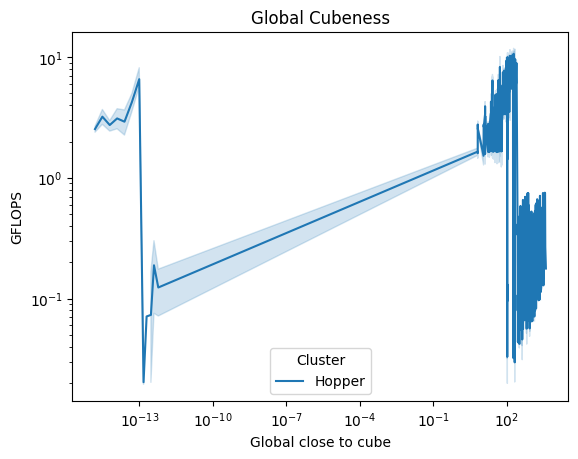

In [156]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global.svg')

In [157]:
past_500 = data[data['Global close to cube'] > 500]
pre_300 = data[data['Global close to cube'] < 300]

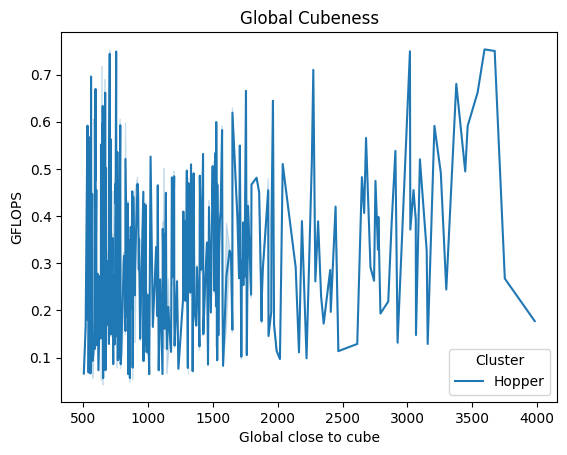

In [158]:
sns.lineplot(past_500[past_500['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global_large.svg')

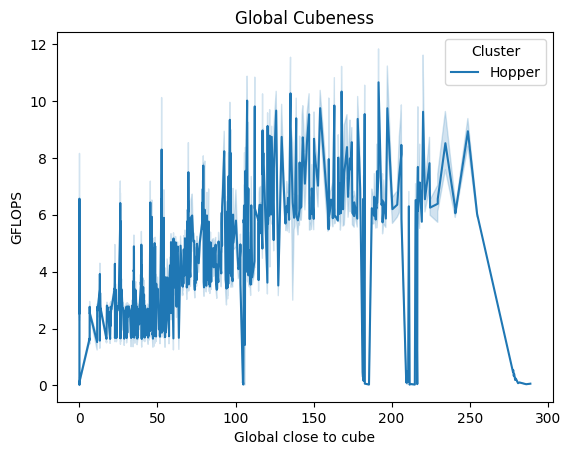

In [159]:
sns.lineplot(pre_300[pre_300['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global_small.svg')

# CPU vs GPU

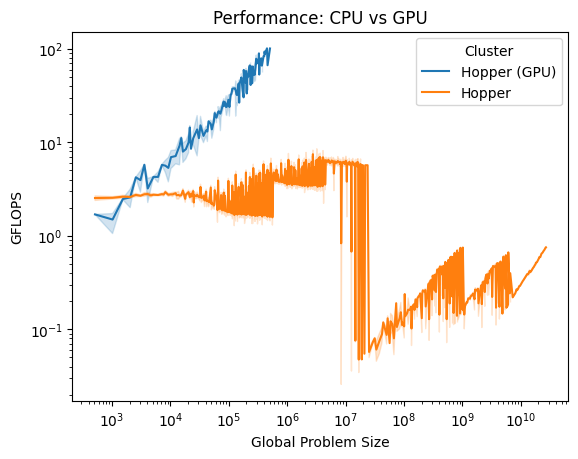

In [160]:
sns.lineplot(data, x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance: CPU vs GPU')
plt.savefig('figures/flops_global_problem_size_cpu_vs_gpu.svg')

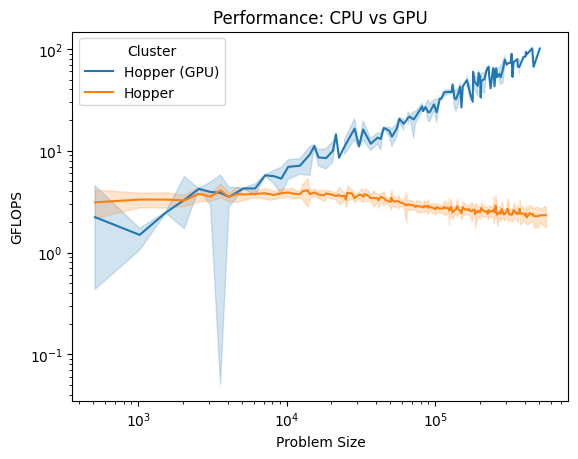

In [161]:
sns.lineplot(data, x="Problem Size", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance: CPU vs GPU')
plt.savefig('figures/flops_local_problem_size_cpu_vs_gpu.svg')

# Ahmdal-like

In [176]:
data_cpu = data[data['Cluster'] == 'Hopper']
data_cpu_one_task_per_node = data_cpu[data_cpu['SLURM_NTASKS_PER_NODE'] == 1]

data_up_to_x_nodes = data_cpu_one_task_per_node[data_cpu_one_task_per_node['SLURM_NNODES'] <= 2]

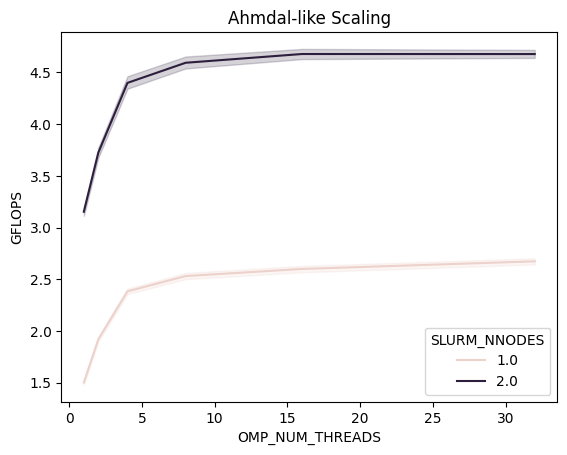

In [177]:
sns.lineplot(data_up_to_x_nodes, x="OMP_NUM_THREADS", y="GFLOPS", hue='SLURM_NNODES')
#plt.xscale('log')
#plt.yscale('log')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Ahmdal-like Scaling')
plt.savefig('figures/flops_ahmdal.svg')

# Parameter combinations

In [164]:
param_sets = []
for name in header:
    vals = data[name].unique()
    vals.sort()
    param_sets.append(vals.astype(int))

In [165]:
param_sets = param_sets[:-1]

In [166]:
param_strings = []
for set in param_sets:
    st = ""
    for pv in set:
        st = st + str(pv) + ", "
    param_strings.append(st[:-2])

In [167]:
param_df = pd.DataFrame(param_strings)

In [168]:
param_df.insert(0, "", header[:-1])

In [169]:
print(param_df.to_latex())

\begin{tabular}{lll}
\toprule
{} &                                          0 \\
\midrule
0 &                      X &          8, 16, 24, 32, 40, 48, 56, 64, 72 \\
1 &                      Y &  8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88 \\
2 &                      Z &  8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88 \\
3 &                   TIME &                                         90 \\
4 &           SLURM\_NNODES &                                    1, 2, 4 \\
5 &  SLURM\_NTASKS\_PER\_NODE &                               1, 2, 16, 32 \\
6 &        OMP\_NUM\_THREADS &                         1, 2, 4, 8, 16, 32 \\
7 &    SLURM\_GPUS\_PER\_NODE &                                    0, 1, 2 \\
\bottomrule
\end{tabular}

